## Create images of nonoverlapping circles

In [ ]:
from fastcore.all import *
from fastai.vision.all import *
from PIL import Image 
import numpy as np 
from matplotlib import pyplot as plt

width = 200
height = 200

# Only do odd numbers to make it a little easier to recognize differences
for num_shapes in [1,3,5,7,9]:
    os.mkdir(f"counts/{num_shapes}")
    for count in range(200):

        img_array = np.zeros((width,height))
        current_centers = []
        valid_counter = 0
        for x in range(width):
            for y in range(height):
                img_array[x,y] = 0 #np.random.random(1)

        while len(current_centers) < num_shapes:
            
            radius = np.random.randint(5,40)
            radius_squared = radius**2
            x_center = np.random.randint(radius, width-radius)
            y_center = np.random.randint(radius, height-radius)

            is_valid = True
            for current_center in current_centers:
                if  np.sqrt((x_center-current_center[0])**2 + (y_center-current_center[1])**2) < radius+current_center[2]:
                    is_valid = False
                    break
            
            if is_valid:
                current_centers.append([x_center, y_center, radius])
                for x in range(x_center-radius,x_center+radius):
                    for y in range(y_center-radius, y_center+radius):
                        if (x-x_center)**2 + (y-y_center)**2 <= radius_squared:
                            img_array[x,y] += 1.0#+np.random.random(1)

        img = Image.fromarray(img_array*255).convert("RGB")
        img.save(f"counts/{num_shapes}/{count}.jpg")


## Set up datablock

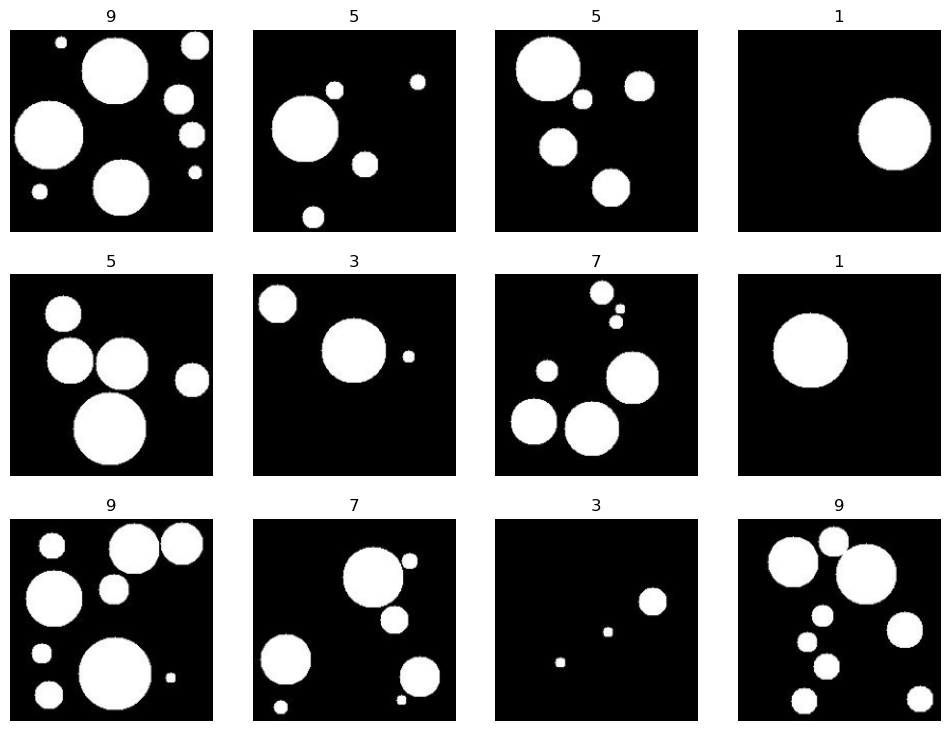

In [7]:
path = Path('counts')
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=12)

## Train using resnet18

/groups/scicompsoft/home/ackermand/miniconda3/envs/fastai/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/groups/scicompsoft/home/ackermand/miniconda3/envs/fastai/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,2.079465,1.580582,0.585000,00:03


epoch,train_loss,valid_loss,error_rate,time
0,0.952081,1.195994,0.505000,00:02
1,0.693729,1.102834,0.470000,00:02
2,0.523817,0.702603,0.285000,00:02
3,0.408439,0.716972,0.280000,00:02
4,0.311713,0.468116,0.180000,00:02
5,0.242146,0.483946,0.155000,00:02
6,0.188023,0.515901,0.150000,00:03
7,0.146223,0.491606,0.165000,00:02
8,0.115901,0.501553,0.170000,00:02
9,0.093905,0.503278,0.175000,00:02


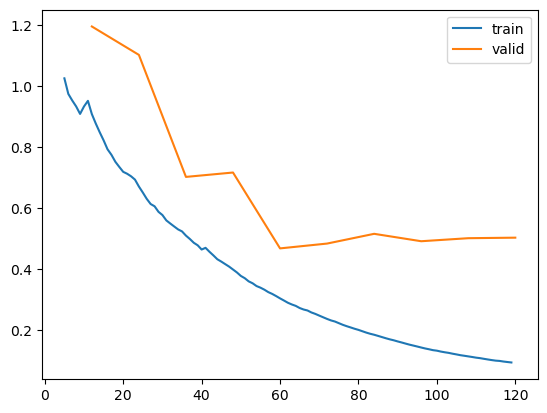

In [8]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

# NOTE: must be done before doing anything else with the learner that may flush the recorder
learn.recorder.plot_loss()

## Export

In [9]:
learn.export('count_10epoch.pkl')

# Plot confusion matrix and top loss images

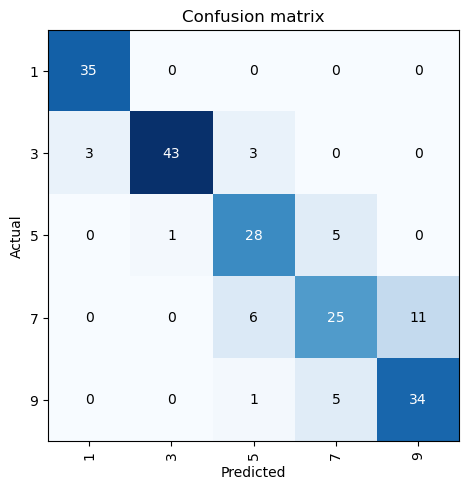

In [10]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(plot_txt=True)

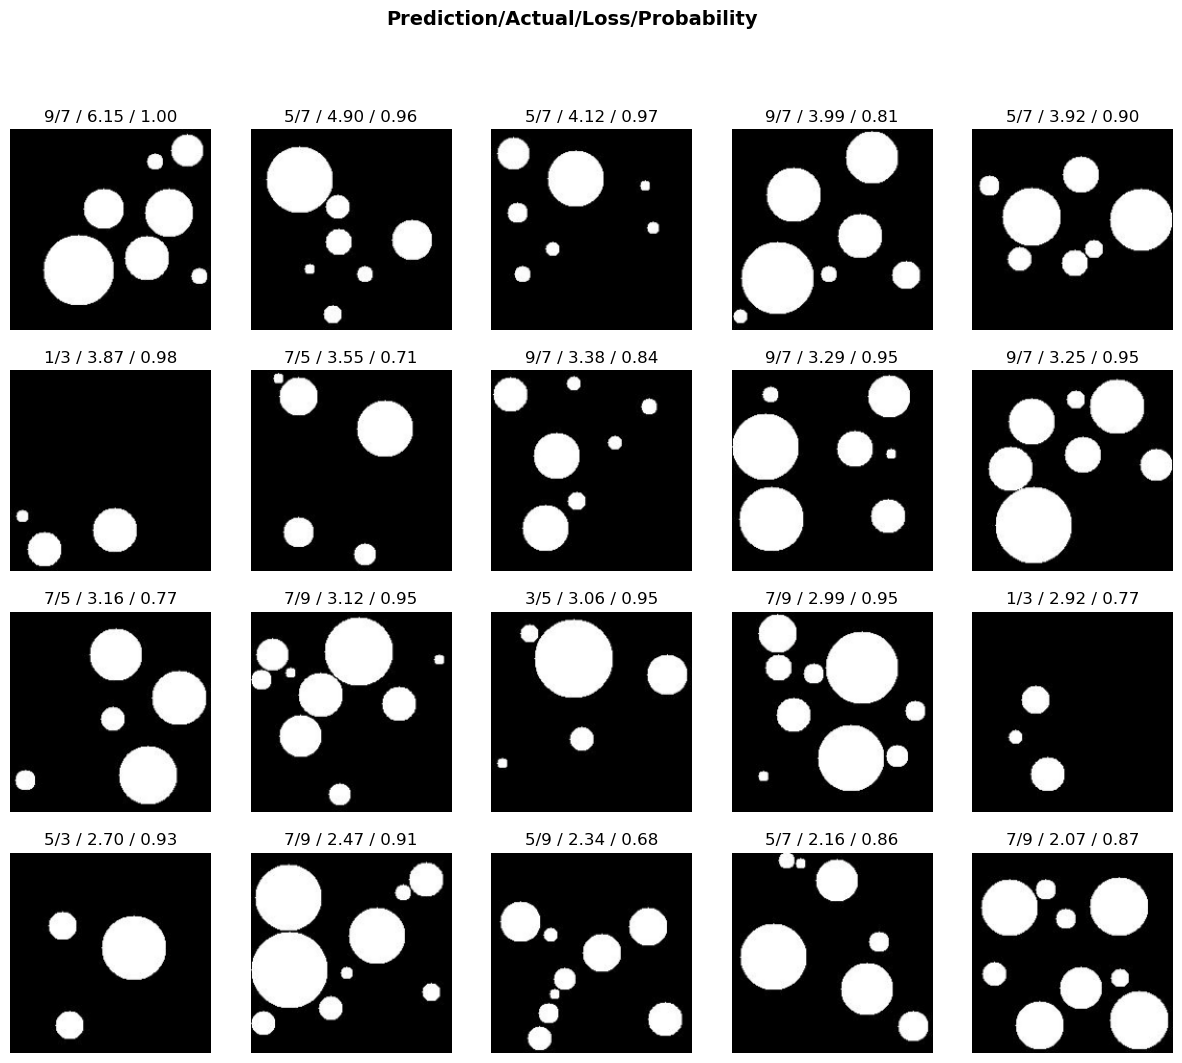

In [11]:
interp.plot_top_losses(20, nrows=4)